<a href="https://colab.research.google.com/github/KadenC2026/2024-2025-Summer-Research/blob/main/NeuralNetworkVaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Approach to Calculating VaR

Epoch  1/50, Loss: 0.022213
Epoch  2/50, Loss: 0.019973
Epoch  3/50, Loss: 0.017821
Epoch  4/50, Loss: 0.015790
Epoch  5/50, Loss: 0.013884
Epoch  6/50, Loss: 0.012107
Epoch  7/50, Loss: 0.010494
Epoch  8/50, Loss: 0.009035
Epoch  9/50, Loss: 0.007742
Epoch 10/50, Loss: 0.006613
Epoch 11/50, Loss: 0.005608
Epoch 12/50, Loss: 0.004717
Epoch 13/50, Loss: 0.003937
Epoch 14/50, Loss: 0.003279
Epoch 15/50, Loss: 0.002741
Epoch 16/50, Loss: 0.002293
Epoch 17/50, Loss: 0.001940
Epoch 18/50, Loss: 0.001650
Epoch 19/50, Loss: 0.001409
Epoch 20/50, Loss: 0.001216
Epoch 21/50, Loss: 0.001058
Epoch 22/50, Loss: 0.000937
Epoch 23/50, Loss: 0.000833
Epoch 24/50, Loss: 0.000756
Epoch 25/50, Loss: 0.000697
Epoch 26/50, Loss: 0.000649
Epoch 27/50, Loss: 0.000611
Epoch 28/50, Loss: 0.000584
Epoch 29/50, Loss: 0.000563
Epoch 30/50, Loss: 0.000547
Epoch 31/50, Loss: 0.000534
Epoch 32/50, Loss: 0.000524
Epoch 33/50, Loss: 0.000516
Epoch 34/50, Loss: 0.000510
Epoch 35/50, Loss: 0.000506
Epoch 36/50, Loss: 0

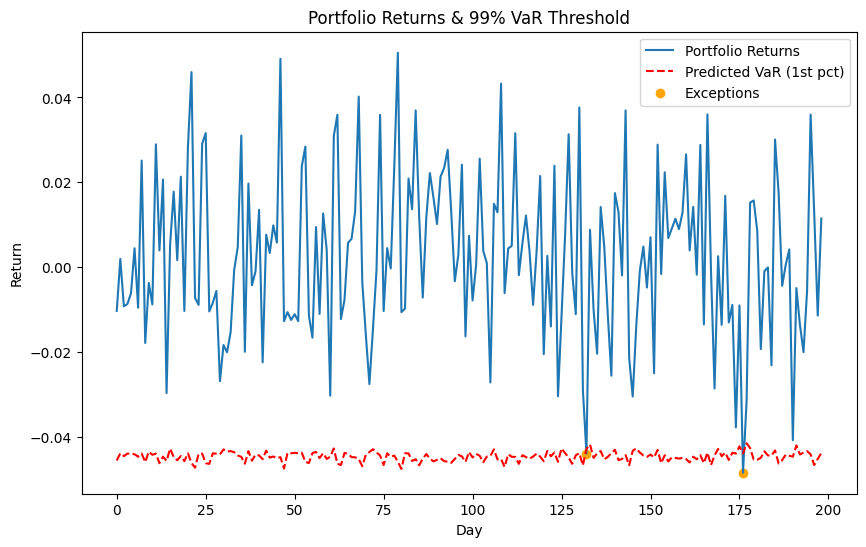

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------
# 1. Data Setup
# ----------------------------------------------

np.random.seed(42)
returns = np.random.normal(0, 0.02, 1000)

train_size = int(0.8 * len(returns))
train_returns = returns[:train_size]
test_returns  = returns[train_size:]

# single‐lag feature
X_train = torch.tensor(train_returns[:-1], dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(train_returns[1:],  dtype=torch.float32).unsqueeze(1)
X_test  = torch.tensor(test_returns[:-1],  dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(test_returns[1:],   dtype=torch.float32).unsqueeze(1)

# ----------------------------------------------
# 2. Quantile‐Regression Network
# ----------------------------------------------

class QuantileNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1  = nn.Linear(1, 64)
        self.fc2  = nn.Linear(64, 32)
        self.fc3  = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

def quantile_loss(y_pred, y_true, quantile):
    error = y_true - y_pred #calculate error
    return torch.mean(torch.max(quantile * error, (quantile - 1) * error))
    # If error is positive (actual > predicted), this term is $\tau (y - \hat y)$
    # If the error is negative (actual < predicted), this term is $(\tau - 1)(y - \hat y)$. Note that $\tau - 1$ is negative when $\tau < 1$, flipping the sign.

# # ── Fix #1 ── lower LR to avoid overshooting, predict the 1st percentile → 99% VaR
confidence_level = 0.01

model = QuantileNN()


# ── Fix #2 ── lower LR to avoid overshooting
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# ----------------------------------------------
# 3. Training
# ----------------------------------------------

epochs = 50
for ep in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss   = quantile_loss(y_pred, y_train, tau)
    loss.backward()
    optimizer.step()
    print(f"Epoch {ep:2d}/{epochs}, Loss: {loss.item():.6f}")

# ----------------------------------------------
# 4. VaR Estimation & Exceptions
# ----------------------------------------------

model.eval()
with torch.no_grad():
    var_pred = model(X_test).squeeze()

exceptions = (y_test.squeeze() < var_pred)
print("Number of Exceptions:", exceptions.sum().item())

# ----------------------------------------------
# 5. Plot
# ----------------------------------------------

plt.figure(figsize=(10,6))
plt.plot( y_test.squeeze().numpy(),      label="Portfolio Returns")
plt.plot( var_pred.numpy(),      '--r',   label="Predicted VaR (1st pct)")
plt.scatter(
    np.where(exceptions.numpy())[0],
    y_test.squeeze().numpy()[exceptions.numpy()],
    c='orange', label="Exceptions"
)
plt.xlabel("Day")
plt.ylabel("Return")
plt.title("Portfolio Returns & 99% VaR Threshold")
plt.legend()
plt.show()


Notes on Debugging:
- Switched confidence_level from 0.99 to 0.01, because we are trying to learn the 1st percentile (the worst 1 % of returns) in order to report a 99 % VaR. Previously using 0.99 meant we are learning the 99th percentile with a large positive return, which is why we were getting all exceptions.
- Lower the Adam Learning Rate from 0.001 -> 0.0001.